# Model training for PLAYGROUNDr
This notebook contains the procedures used to develop the methods and models applied in the PLAYGROUNDr web app to identify park amenities from Google Reviews. It demonstrates the text cleaning procedures, database wrangling, and feature engineering necessary to build the models. It also shows the process used to choose which model and word embedding to use, and validation.

### Due to Google terms of service, the data used in this notebook cannot be shared, and this notebook is meant to be viewed statically.

## Data wrangling
Let's start the database wrangling by importing all of the packages we'll need to handle data.

In [1]:
import xml.etree.cElementTree as et # Allows parsing of the Toronto database, which is in XML
import insight_project_util as util # Contains a function to parse the Toronto base specifically
import numpy as np
import pandas as pd
import json
from fuzzywuzzy import fuzz # A package that allows fuzzy matching of strings, to master the different databases
from matplotlib import pyplot as plt
# I also define a personal style, mainly to increase the font size of plot labels
plt.style.use(['basic_size_style.mplstyle','basic_color_style.mplstyle'])

In [5]:
# Filenames for databases and output model files
on_database_name = "toronto-facilities-data.xml"
full_database_name = "database_20200121.json"
google_review_database_name = 'continuous_google_reviews_all_20200120.json'
model_file_name = "data/classifier.mod"
tfidf_file_name = "data/TFIDFmodel.mod"
SVD_file_name = "data/SVDmodel.mod"

In [6]:
# Load in the toronto database
on_dict = {
        'name' : 'LocationName', # There is poor matching between database names and names in the Toronto Parks and Rec website
        'city' : 'PostalCode',
        'state' : 'state',
        'playground' : ['Playground','Splash Pad'],
        'splashpad' : 'Splash Pad',
        'pool' : ['Outdoor Pool','Pool','Indoor Pool','Wading Pool'],
        'rink' : 'Outdoor Rink',
        'restroom' : 'Washroom', # Some exploratory checking shows that the database misses some washrooms
        'sports_field' : ['Sport Field','Ball Diamond','Outdoor Track'],
        'dog_park' : 'Dogs Off-Leash Area',
        'skate_park' : 'Skateboard Park',
        'beach' : [] # There are no ocean beaches in Toronto
        }

# The Toronto, ON database comes in a less-than-ideal XML format that requires
# additional pre-processing to get in the same format (boolean amenity columns)
# as the other databases.
on_database_initial = util.torontoXML2df(et.parse(on_database_name).getroot())
# Make the 'FacilityDisplayName' categorical var into a series of dummy vars
on_dummies = on_database_initial['FacilityDisplayName'].str.get_dummies()
# Create a new database with only one entry per park
on_database = pd.DataFrame(columns=['LocationName','PostalCode']+list(on_dummies.columns))
on_database['LocationName'] = on_database_initial['LocationName'].unique()
on_database = on_database.set_index('LocationName')
# Move data from the entries in on_dummies to on_database
for col in on_dummies.columns:
    on_database[col] = np.zeros(on_database.shape[0])
for ii in np.arange(on_database_initial.shape[0]):
    on_database.loc[on_database_initial['LocationName'].iloc[ii],on_database_initial['FacilityDisplayName'].iloc[ii]] \
        += on_dummies[on_database_initial['FacilityDisplayName'].iloc[ii]].iloc[ii]
    on_database.loc[on_database_initial['LocationName'].iloc[ii],'PostalCode'] = on_database_initial['PostalCode'].iloc[ii]
on_database_initial = on_database.reset_index()

In [7]:
# Add a variable to the database to distinguish from other databases
on_database = on_database_initial
on_database['state'] = ['on']*on_database.shape[0]

# Initialize a new database with cleaned column names and the values from the 
# old database
full_database = pd.DataFrame(columns=on_dict.keys())
dbase = on_database
keys = on_dict
amenity_vars = [col for col in full_database.columns if col!='city' and col!='name' and col!='state']
full_database['name'] = dbase[keys['name']]
full_database['city'] = dbase[keys['city']]
full_database['state'] = dbase[keys['state']]
# Only add those variables that we care about, from the Toronto database
for col in amenity_vars:
    if isinstance(keys[col],list):
        if keys[col]:
            temp_array = np.zeros(dbase.shape[0])
            for item in keys[col]:
                temp_array += np.array(dbase[item])
        else:
            temp_array = np.zeros(full_database.shape[0])
    else:
        temp_array = np.array(dbase[keys[col]])
    full_database[col] = [int(x>0) for x in temp_array]
full_database['google_name'] = ['']*full_database.shape[0]
full_database['is_type_park'] = np.ones(full_database.shape[0])*np.nan
full_database['num_reviews'] = np.ones(full_database.shape[0])*np.nan
full_database['reviews'] = ['']*full_database.shape[0]

# Load in our database with all of the reviews and attach the reviews to our
# database
review_database = pd.read_json(full_database_name,orient='records',lines='True')
full_database.loc[:,'is_type_park'] = list(review_database.loc[review_database['state']=='on','is_type_park'])
full_database.loc[:,'num_reviews'] = list(review_database.loc[review_database['state']=='on','num_reviews'])   
full_database.loc[:,'reviews'] = list(review_database.loc[review_database['state']=='on','reviews'])

Unfortunately, when querying Google and Yelp for reviews, sometimes the results don't match the query very well. The Google Places API especially likes to confidently return results when they don't find a strong match for the query (you've likely experienced this once or twice while using Google Maps and the first place they pull up has none of the search words in its name or description).

The following code analyzes the degree to which the Google place names match the municipal database names, and keeps the reviews only for those that match somewhat.

In [8]:
# Remove records where google name differs widely from database name
# Add the name google places returned, from the output file saved during scraping
target_columns = ['name', 'city', 'state'] # Target database column name from which to construct the text query
with open(google_review_database_name) as fp:
    review_database1 = pd.DataFrame(json.load(fp))

name_dict = {}
for result in review_database1['reviews']:
    if result:
        name_dict[result['result']['query']] = result['result']['name']

for ii in full_database.index:
    query = ' '.join([str(full_database.loc[ii,x]) for x in target_columns])
    if query in name_dict.keys():
        full_database.loc[ii,'google_name'] = name_dict[query]

# Remove records where the retrieved google_name strays too far from database
# name
out_rows = []
for dname, gname in zip(list(full_database.loc[:,'name']),list(full_database.loc[:,'google_name'])):
    dname = dname.replace(' cc',' community centre').replace(' crc', 'community recreation centre')
    out_rows.append(fuzz.partial_token_set_ratio(dname.lower(),gname.lower()))
out_rows = np.array(out_rows)
full_database = full_database.loc[(out_rows==14) + (out_rows>=50)]
full_database = full_database.reset_index()

Finally, we extract the data from the database into variables that can be given directly to text vectorizers and classification models.

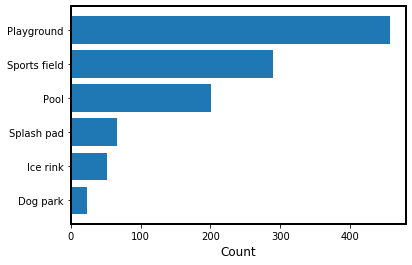

In [9]:
# Process the text data into model input and corpus
amenity_vars = ['playground', 'sports_field','pool','splashpad','rink','dog_park']
y = np.array(full_database.loc[:,amenity_vars])
X = list(full_database['reviews'])

# Plot the distribution of amenities in the Toronto dataset
fig, ax = plt.subplots()
ax.grid = True
ax.barh(np.arange(6),np.sum(np.array(full_database.loc[:,amenity_vars]), axis=0))
ax.set_yticks(np.arange(6))
ax.set_yticklabels(['Playground','Sports field','Pool','Splash pad','Ice rink','Dog park'])
ax.invert_yaxis()
ax.set_xlabel('Count')
plt.show()

## Word embedding development
So far we have cleaned the data a little bit and collected it into useful objects. Next, we have to deep clean and vectorize the text data. Three .)methods are applied to vectorize the data:
1. Bag of words with unigrams
2. Term frequency-Inverse document frequency (TF-IDF) with unigrams and bigrams
3. Word2Vec (actually, the FastText variant)

In [10]:
# Import packages for the modeling portion
from gensim.models import FastText #FastText can provide vectors for out-of-vocab words
from sklearn.model_selection import cross_validate, GridSearchCV # Utilities for cross-validation and hyperparameter tuning
from sklearn.naive_bayes import GaussianNB # Naive Bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD # To reduce the number of TF-IDF features, we try latent semantic analysis
from nltk.stem import WordNetLemmatizer # Reduces words to their basic form
from sklearn import metrics
from collections import defaultdict
import re
from nltk.corpus import stopwords # Common words to remove before analysis

In [11]:
# Let's define the various word embedding tools we want to test
# Let's remove stop words and needless punctuation and lemmatize the words
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\.\n]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z ]')
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def text_prepare(text):
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, '',text)# delete symbols which are in BAD_SYMBOLS_RE from text
#    text = ' '.join([x for x in text.split() if x not in STOPWORDS])# delete stopwords from text and don't lemmatize
    text = ' '.join([lemmatizer.lemmatize(x) for x in text.split() if x not in STOPWORDS])# delete stopwords from text and lemmatize
    return text

# Clean review strings and generate test and training datasets
X_vector_train = []
for review in list(review_database['reviews']):
    for rev in review.split(r'|||'):
        clean = re.split('[.!?;]',rev)
        X_vector_train += [text_prepare(sent.replace('/n',' ')).split() for sent in clean if sent]

X_vector_train_tfidf = [text_prepare(x) for x in list(review_database['reviews'])]

# Clean the reviews and then remove reviews that have been emptied by the 
# cleaning
X = [text_prepare(x) for x in X]
y = np.array([y[ii,:] for ii in full_database.index if X[ii]])
X = [x for x in X if x]

# Perform an 80/20 train/test split on the data
testinds = np.random.choice(len(X),round(0.2*len(X)))
traininds = [x for x in range(len(X)) if x not in testinds]
X_train = np.array(X)[traininds]
y_train = y[traininds,:]
X_test = np.array(X)[testinds]
y_test = y[testinds,:]

The first vectorizer we try is a bag of words model. Normally, bag of words generates a vector of word counts (integers) with length equal to the vocabulary size. Our vocabulary size is huge, so we reduce the number of features by selecting only the first 2000. Additionally, we make the data a little more amenable to the Gaussian Naive Bayes classifier, and variable length reviews, by dividing the word counts by the total number of words in each review. This way, long and short reviews should have similar magnitude vector values.

In [12]:
N = 2000 #Number of most popular words to keep in the bag of words model
def bag_of_words_dict(N,all_data):
    
    # Derive raw word counts for each word in the dataset
    word_freq = defaultdict(int)
    for sent in X_vector_train:
        for word in sent:
            word_freq[word] += 1
    
    # Sort the words based on frequency
    word_freq = sorted(word_freq, key=word_freq.get, reverse=True)
    
    # Create a list and a dict for converting between indices in a bag-of-words
    # vector and the word represented at each index
    index2word = word_freq[:N]
    word2index = dict()
    for ii in range(len(index2word)):    
        word2index[index2word[ii]] = ii
       
    return (index2word, word2index)

index2word, word2index = bag_of_words_dict(N,X_vector_train)

def bag_of_words_vectorize(words,word2index):
    vect = np.zeros([1,len(word2index.keys())])
    for word in words.split():
        if word in word2index.keys():
            vect[0,word2index[word]] += 1
    return vect

X_train_bow = np.array([bag_of_words_vectorize(review,word2index)/len(review.split()) for review in X_train]).squeeze()
X_test_bow = np.array([bag_of_words_vectorize(review,word2index)/len(review.split()) for review in X_test]).squeeze()

Next we develop at TF-IDF vectorizer, which penalizes the most frequent tokens, because if a token appears in every review, it's probably not useful for distinguishing amenities that vary between reviews. To reduce the number of TF-IDF features, we perform truncated SVD. This is basically a Principal Component Analysis (PCA) that works well on sparse data. Often, when TF-IDF is coupled with truncated SVD it's termed Latent Semantic Analysis and is useful for comparing documents. Here it's just used to engineer features.

In [13]:
# Now generate a tfidf vectorizer with bigrams
tfidf_vectorizer = TfidfVectorizer(input='content',ngram_range=(1,2),max_df=0.9,min_df=5)
tfidf_vectorizer = tfidf_vectorizer.fit(X_vector_train_tfidf)
dim_limiter = TruncatedSVD(n_components=2000)
dim_limiter.fit(tfidf_vectorizer.transform(X_vector_train_tfidf))
X_train_tfidf = dim_limiter.transform(tfidf_vectorizer.transform(X_train))
X_test_tfidf = dim_limiter.transform(tfidf_vectorizer.transform(X_test))

As a final attempt to reduce the number of features, we'll try a method that retains a lot of the context in the words while using a very small feature vector. We can use FastText, a version of Word2Vec.  Note, in this version we generate a 128-length vector, less than the number of samples we're using to train most of the amenities. However, I also tried 256 and 512-length versions that produced negigibly better results. Thus, I stick with the smaller vectors, which are less likely to overload your computer's memory.

In [14]:
## Train the word2vec model
# Let's create a basic word2vec model using our full review corpus
# Parameters
vector_size = 128
window_size = 5
train_epochs = 5

w2v_model = FastText(min_count=5,
                     window=window_size,
                     size=vector_size,
                     workers=4)
w2v_model.build_vocab(X_vector_train)
w2v_model.train(X_vector_train,total_examples=w2v_model.corpus_count,epochs=train_epochs)
w2v_model.init_sims(replace=True)


# Let's vectorize X by applying the vectorizer to each word and summing over
# each review, then normalize number of reviews

def w2v_vectorize(X,model):
    X_vect = np.zeros([len(X),model.trainables.layer1_size])
    for ii in np.arange(len(X)):
        temp = np.zeros(vector_size)
        for word in X[ii].split():
            temp += w2v_model[word]
        X_vect[ii,:] = temp / len(X[ii].split())
    return X_vect
X_train_w2v = w2v_vectorize(X_train,w2v_model)
X_test_w2v = w2v_vectorize(X_test,w2v_model)

/home/bramante/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## Model development
Now that we have three different word embeddings, I decided to try three different models on each word embedding:
1. Naive Bayes
2. Logistic regression
3. Random forest

Naive Bayes is one of the classic NLP algorithms because it produces relatively good classification power with small training sample sizes, essentially no hyperparameter tuning, and little computational resources.

Logistic regression is also one of the most basic classifiers in our toolkit, with a tunable regularization parameter that's going to be very important to prevent overfitting on our thousands-of-words features vectors.

Random forest is a more sophisticated classification algorithm that takes a lot of computational resources to train but can produce superior results.

For each of these models, we perform 5-fold cross-validation on the training set only, to tune hyperparameters. After tuning, we compare models using the mean cross-validation score for the tuned model. The 20% test set is held in reserve to validate the model we finally decide upon.

In [17]:

## How about we start building models on top of these embeddings? Let's use 
# f2score as our metric
f2_score = metrics.make_scorer(metrics.fbeta_score,beta=0.5)  
num_Cs = 20 #Number of regularization parameters to try in range 1e-4:1e4

# For each amenity, train a separate logistic regression and do a search of
# the optimal regularization parameter
bow_lrc = []
bow_lrc_f2 = []
bow_lrc_auc = []
bow_lrc_prec = []
for ii in range(y_train.shape[1]):
    lrc = LogisticRegressionCV(cv=5, Cs=num_Cs,class_weight='balanced',solver='liblinear',max_iter=1000,dual=True,scoring=f2_score, refit=True, n_jobs=2)
    lrc.fit(X_train_bow,y_train[:,ii])
    bow_lrc_f2.append(lrc.score(X_train_bow,y_train[:,ii]))
    bow_lrc_auc.append(metrics.roc_auc_score(y_train[:,ii],lrc.predict_proba(X_train_bow)[:,1]))
    bow_lrc_prec.append(metrics.precision_score(y_train[:,ii],lrc.predict(X_train_bow)))
    bow_lrc.append(lrc)

tfidf_lrc = []
tfidf_lrc_f2 = []
tfidf_lrc_auc = []
tfidf_lrc_prec = []
for ii in range(y_train.shape[1]):
    lrc = LogisticRegressionCV(cv=5, Cs=num_Cs,class_weight='balanced',solver='liblinear',max_iter=1000,dual=True,scoring=f2_score, refit=True, n_jobs=2)
    lrc.fit(X_train_tfidf,y_train[:,ii])
    tfidf_lrc_f2.append(lrc.score(X_train_tfidf,y_train[:,ii]))
    tfidf_lrc_auc.append(metrics.roc_auc_score(y_train[:,ii],lrc.predict_proba(X_train_tfidf)[:,1]))
    tfidf_lrc_prec.append(metrics.precision_score(y_train[:,ii],lrc.predict(X_train_tfidf)))
    tfidf_lrc.append(lrc)
    
w2v_lrc = []
w2v_lrc_f2 = []
w2v_lrc_auc = []
w2v_lrc_prec = []
for ii in range(y_train.shape[1]):
    lrc = LogisticRegressionCV(cv=5, Cs=num_Cs,class_weight='balanced',solver='liblinear',max_iter=1000,dual=True,scoring=f2_score, refit=True, n_jobs=2)
    lrc.fit(X_train_w2v,y_train[:,ii])
    w2v_lrc_f2.append(lrc.score(X_train_w2v,y_train[:,ii]))
    w2v_lrc_auc.append(metrics.roc_auc_score(y_train[:,ii],lrc.predict_proba(X_train_w2v)[:,1]))
    w2v_lrc_prec.append(metrics.precision_score(y_train[:,ii],lrc.predict(X_train_w2v)))
    w2v_lrc.append(lrc)

In [18]:
# Let's generate Naive Bayes' classifiers.
scoring = {
           'f2':f2_score, 
           'auc' : metrics.make_scorer(metrics.roc_auc_score), 
           'prec' : metrics.make_scorer(metrics.precision_score)
           }
bow_cnb = []
bow_cnb_f2 = []
bow_cnb_auc = []
bow_cnb_prec = []
for ii in range(y_train.shape[1]):
    cnb = GaussianNB()
    cnbcv = cross_validate(cnb,X_train_bow,y_train[:,ii],cv=5,scoring=scoring, n_jobs=2)
    bow_cnb_f2.append(np.mean(cnbcv['test_f2']))
    bow_cnb_auc.append(np.mean(cnbcv['test_auc']))
    bow_cnb_prec.append(np.mean(cnbcv['test_prec']))
    
tfidf_cnb = []
tfidf_cnb_f2 = []
tfidf_cnb_auc = []
tfidf_cnb_prec = []
for ii in range(y_train.shape[1]):
    cnb = GaussianNB()
    cnbcv = cross_validate(cnb,X_train_tfidf,y_train[:,ii],cv=5,scoring=scoring, n_jobs=2)
    tfidf_cnb_f2.append(np.mean(cnbcv['test_f2']))
    tfidf_cnb_auc.append(np.mean(cnbcv['test_auc']))
    tfidf_cnb_prec.append(np.mean(cnbcv['test_prec']))
    
w2v_cnb = []
w2v_cnb_f2 = []
w2v_cnb_auc = []
w2v_cnb_prec = []
for ii in range(y_train.shape[1]):
    cnb = GaussianNB()
    cnbcv = cross_validate(cnb,X_train_w2v,y_train[:,ii],cv=5,scoring=scoring, n_jobs=2)
    w2v_cnb_f2.append(np.mean(cnbcv['test_f2']))
    w2v_cnb_auc.append(np.mean(cnbcv['test_auc']))
    w2v_cnb_prec.append(np.mean(cnbcv['test_prec']))

In [19]:
# What about Random Forest
    # Parameters to search through using GridSearchCV
params = {
        'max_depth' : [5,10,20,50],
        'n_estimators' : [100,1000,2000,5000]
        }

#Bag of words first
bow_rfc = []
bow_rfc_f2 = []
bow_rfc_auc = []
bow_rfc_prec = []
for ii in range(y_train.shape[1]):
    gcv = GridSearchCV(RandomForestClassifier(class_weight='balanced'),params,cv=5,n_jobs=2,scoring=scoring,refit='f2')
    gcv.fit(X_train_bow,y_train[:,ii])
    metric_ind = np.argmax(gcv.cv_results_['rank_test_f2']==1)
    bow_rfc.append(gcv.best_estimator_)
    bow_rfc_f2.append(gcv.cv_results_['mean_test_f2'][metric_ind])
    bow_rfc_auc.append(gcv.cv_results_['mean_test_auc'][metric_ind])
    bow_rfc_prec.append(gcv.cv_results_['mean_test_prec'][metric_ind])
    
# TF-IDF
tfidf_rfc = []
tfidf_rfc_f2 = []
tfidf_rfc_auc = []
tfidf_rfc_prec = []
for ii in range(y_train.shape[1]):
    gcv = GridSearchCV(RandomForestClassifier(class_weight='balanced'),params,cv=5,n_jobs=2,scoring=scoring,refit='f2')
    gcv.fit(X_train_tfidf,y_train[:,ii])
    metric_ind = np.argmax(gcv.cv_results_['rank_test_f2']==1)
    tfidf_rfc.append(gcv.best_estimator_)
    tfidf_rfc_f2.append(gcv.cv_results_['mean_test_f2'][metric_ind])
    tfidf_rfc_auc.append(gcv.cv_results_['mean_test_auc'][metric_ind])
    tfidf_rfc_prec.append(gcv.cv_results_['mean_test_prec'][metric_ind])

#W2V
w2v_rfc = []
w2v_rfc_f2 = []
w2v_rfc_auc = []
w2v_rfc_prec = []
for ii in range(y_train.shape[1]):
    gcv = GridSearchCV(RandomForestClassifier(class_weight='balanced'),params,cv=5,n_jobs=2,scoring=scoring,refit='f2')
    gcv.fit(X_train_w2v,y_train[:,ii])
    metric_ind = np.argmax(gcv.cv_results_['rank_test_f2']==1)
    w2v_rfc.append(gcv.best_estimator_)
    w2v_rfc_f2.append(gcv.cv_results_['mean_test_f2'][metric_ind])
    w2v_rfc_auc.append(gcv.cv_results_['mean_test_auc'][metric_ind])
    w2v_rfc_prec.append(gcv.cv_results_['mean_test_prec'][metric_ind])

After tuning all of the models and calculating their precision, AUC, and f2 (or f0.5) score, we compare the models. It turns out that the Logistic regression based on TF-IDF performs best. Its performance decreases slightly on the test set, which could indicate a degree of over-fitting, but the test set precision is still better than that for the Naive Bayes and random forest models. Also, as we will see, the Bag of Words models appear to have a much greater over-fitting problem.

Text(0.5, 0, 'AUC')

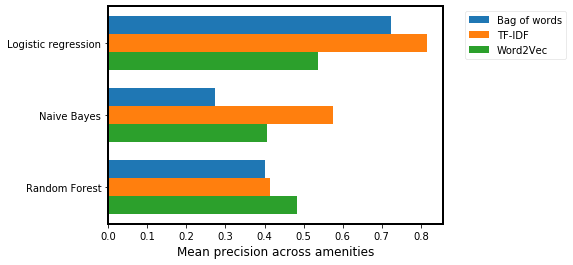

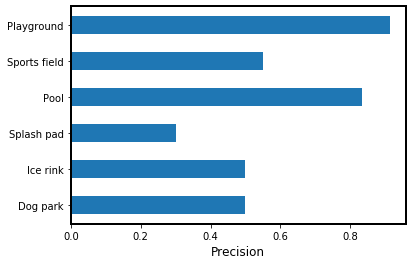

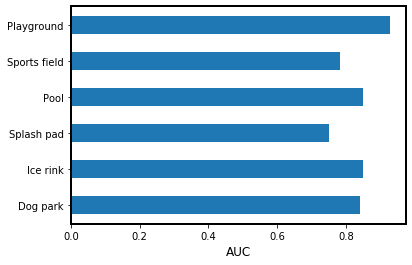

In [20]:
# Plot the average precision of each modeling method
barwidth = 0.25
w2v_prec = [np.mean(w2v_lrc_prec),np.mean(w2v_cnb_prec),np.mean(w2v_rfc_prec)]
tfidf_prec = [np.mean(tfidf_lrc_prec),np.mean(tfidf_cnb_prec),np.mean(tfidf_rfc_prec)]
bow_prec = [np.mean(bow_lrc_prec),np.mean(bow_cnb_prec),np.mean(bow_rfc_prec)]

fig, ax = plt.subplots()
yticks = np.arange(3)
yticks2 = yticks + barwidth
yticks3 = yticks2 + barwidth
ax.barh(yticks,bow_prec,height=barwidth,label='Bag of words')
ax.barh(yticks2,tfidf_prec,height=barwidth,label='TF-IDF')
ax.barh(yticks3,w2v_prec,height=barwidth,label='Word2Vec')
ax.set_yticks(yticks2)
ax.set_yticklabels(['Logistic regression', 'Naive Bayes', 'Random Forest'])
ax.invert_yaxis()
ax.set_xlabel('Mean precision across amenities')
ax.legend(bbox_to_anchor=(1.05,1))

# Now let's plot test set precision for each class
amenity_names = ['Playground','Sports field','Pool','Splash pad','Ice rink','Dog park']
winning_prec = [metrics.precision_score(y_test[:,ii],tfidf_lrc[ii].predict(X_test_tfidf)) for ii in range(len(amenity_vars))]
fig, ax = plt.subplots()
barwidth = 0.5
yticks = np.arange(len(winning_prec))
ax.barh(yticks,winning_prec, height=barwidth)
ax.set_yticks(yticks)
ax.set_yticklabels(amenity_names)
ax.invert_yaxis()
ax.set_xlabel('Precision')
    
# Now let's plot test set auc for each class
winning_auc = [metrics.roc_auc_score(y_test[:,ii],tfidf_lrc[ii].predict_proba(X_test_tfidf)[:,1]) for ii in range(len(amenity_vars))]
fig, ax = plt.subplots()
barwidth = 0.5
yticks = np.arange(len(winning_prec))
ax.barh(yticks,winning_auc, height=barwidth)
ax.set_yticks(yticks)
ax.set_yticklabels(amenity_names)
ax.invert_yaxis()
ax.set_xlabel('AUC')

But what words are driving the predictions most? Since we transformed the TF-IDF data tp reduce the number of dimensions, we can't look at those models, but we can probably get a good idea by looking at the bag of words models that performed similarly.

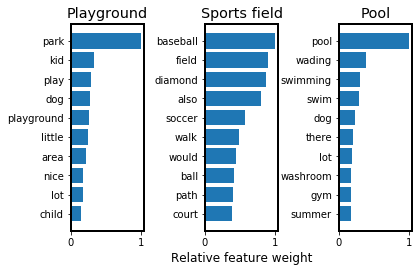

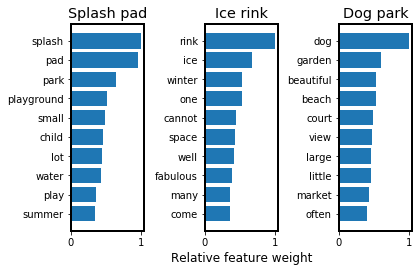

In [26]:
num_words = 10 # Number of words to plot
fig, ax = plt.subplots(1,3)
fig.tight_layout(pad=3)
for ii in range(3):
    yticks = np.arange(num_words)
    sort_ind = np.argsort(-bow_lrc[ii].coef_)
    sorted_coef = bow_lrc[ii].coef_[0,sort_ind]
    yticklabels = [index2word[x] for x in sort_ind[0,:num_words].flatten().tolist()]
    ax[ii].barh(yticks,sorted_coef[0,:num_words]/sorted_coef[0,0])
    ax[ii].set_yticks(yticks)
    ax[ii].set_yticklabels(yticklabels)
    ax[ii].invert_yaxis()
    ax[ii].set_title(amenity_names[ii])
    if ii == 1:
        ax[ii].set_xlabel('Relative feature weight')


fig, ax = plt.subplots(1,3)
fig.tight_layout(pad=3)
for ii in np.arange(3,6,1):
    yticks = np.arange(num_words)
    sort_ind = np.argsort(-bow_lrc[ii].coef_)
    sorted_coef = bow_lrc[ii].coef_[0,sort_ind]
    yticklabels = [index2word[x] for x in sort_ind[0,:num_words].flatten().tolist()]
    ax[ii-3].barh(yticks,sorted_coef[0,:num_words]/sorted_coef[0,0])
    ax[ii-3].set_yticks(yticks)
    ax[ii-3].set_yticklabels(yticklabels)
    ax[ii-3].invert_yaxis()
    ax[ii-3].set_title(amenity_names[ii])
    if ii-3 == 1:
        ax[ii-3].set_xlabel('Relative feature weight')

Some of the highest words make sense and probably have strong discriminative power, but some do not. For example, "park" is the highest-weighted token for Playgrounds, but its use is probably not restricted to reviews of just those parks that playgrounds. Similarly, the word "also" is supposed to be pretty predictive of Sports field, which seems not reasonable (unless their descriptions are only included in reviews as an after-thought). The distribution of coefficient weights for the different amenities is also telling. Aside from "park", the first ten Playground terms are all weighted within a factor of two of each other. Similarly for the first ten words in Sports Field. However, for Pool, the word "pool" receives a much higher weight than the other first ten words, which are thereafter similar in magnitude. This could indicate that for some amenities like Pool, the logistic regression collapses to a keyword search.

As mentioned briefly before, the fact that the bag of words (BOW) model puts so much emphasis on words seemingly unrelated to the amenities they predict could indicate significat overfitting. And if we compare the BOW regularization parameters to the model trained with TF-IDF vectors, we see that the BOW model was optimized with much weaker (but greater in magnitude) regularization parameters, potentially signalling that over-fitting was an issue even with cross-validation:

In [22]:
[mod.C_ for mod in bow_lrc]

[array([4.2813324]),
 array([78.47599704]),
 array([78.47599704]),
 array([0.00483293]),
 array([1438.44988829]),
 array([78.47599704])]

In [23]:
[mod.C_ for mod in tfidf_lrc]

[array([1.62377674]),
 array([1.62377674]),
 array([1.62377674]),
 array([0.08858668]),
 array([29.76351442]),
 array([0.61584821])]

As it turns out, the cross-validated TF-IDF + SVD + logistic regression model performs nearly the same as an earlier model that did not use SVD, so I stuck with the earlier model, which just takes the 2000 most frequent terms. N.B. By taking the most frequent terms from the TF-IDF, I've limited the usefulness of the inverse document frequency weighting, but empirically it still works.